# REMOVE OUTLIERS

In [1]:
library(glmGamPoi)
library(Seurat)
library(glue)
library(ggplot2)

Attaching SeuratObject


Attaching package: ‘ggplot2’


The following object is masked from ‘package:glmGamPoi’:

    vars




Useful Links:

https://rdrr.io/bioc/glmGamPoi/f/vignettes/glmGamPoi.Rmd
https://const-ae.name/post/2021-01-24-gamma-poisson-distribution/gamma-poisson-reference/
https://stat.ethz.ch/R-manual/R-devel/library/stats/html/NegBinomial.html
https://github.com/const-ae/glmGamPoi
https://rdrr.io/bioc/glmGamPoi/man/glm_gp.html

### Testing glmGamPoi

In [32]:
# simulating from a negative binomial 500 times represetning 500 cells from the same cell type with 100 genes
# overdispersion = 1/size
# mu corresponds to the mean of the negative binomial
mu = 5
size = 1/0.7
counts = replicate(n=500, rnbinom(n = 10000, mu = mu, size = 1/0.7))

# design = ~ 1 means that an intercept-only model is fit
fit <- glm_gp(counts, design = ~ 1, overdispersion_shrinkage = FALSE)

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”


In [33]:
# Mus are the dimensionality of the data and are a parameters that can be inputted into the NBinom distribution instead of p (probability of success)
# Mu is mappable to every cell for every gene
# to compute the Mu for a group of cells (say a particular cell type, just take the mean of the Mus)
dim(summary(fit)$Mu)
# overdispersion is related to the size when simulating NBinom
# overdispersion is mappable to every gene
length(summary(fit)$overdispersions)

[1] 10000   500

[1] 10000

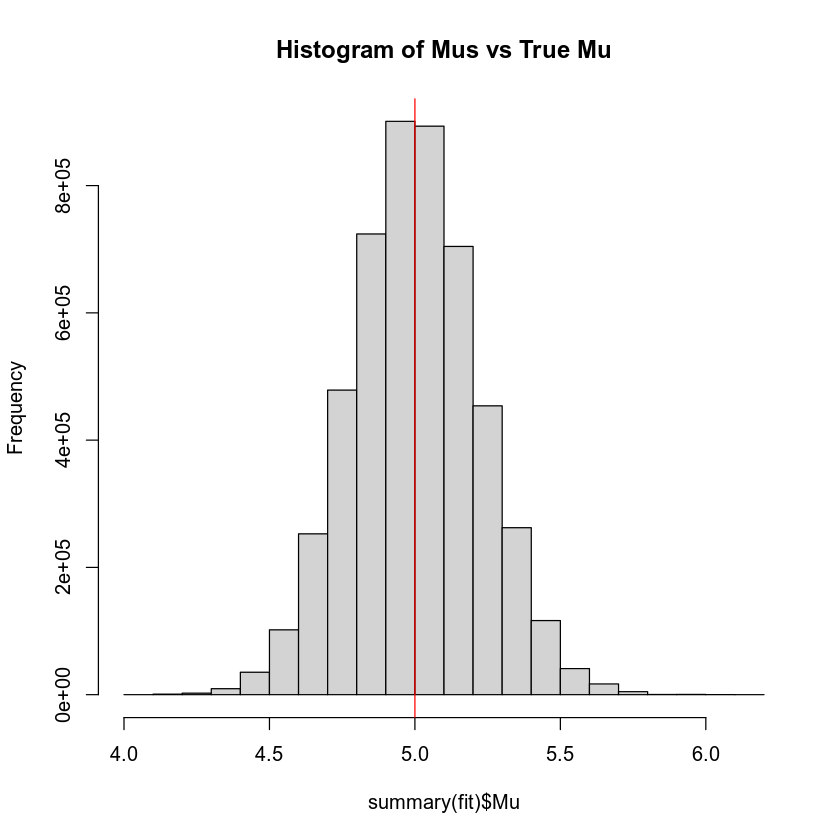

In [35]:
hist(summary(fit)$Mu, main = "Histogram of Mus vs True Mu")
abline(v=mu, col="Red")

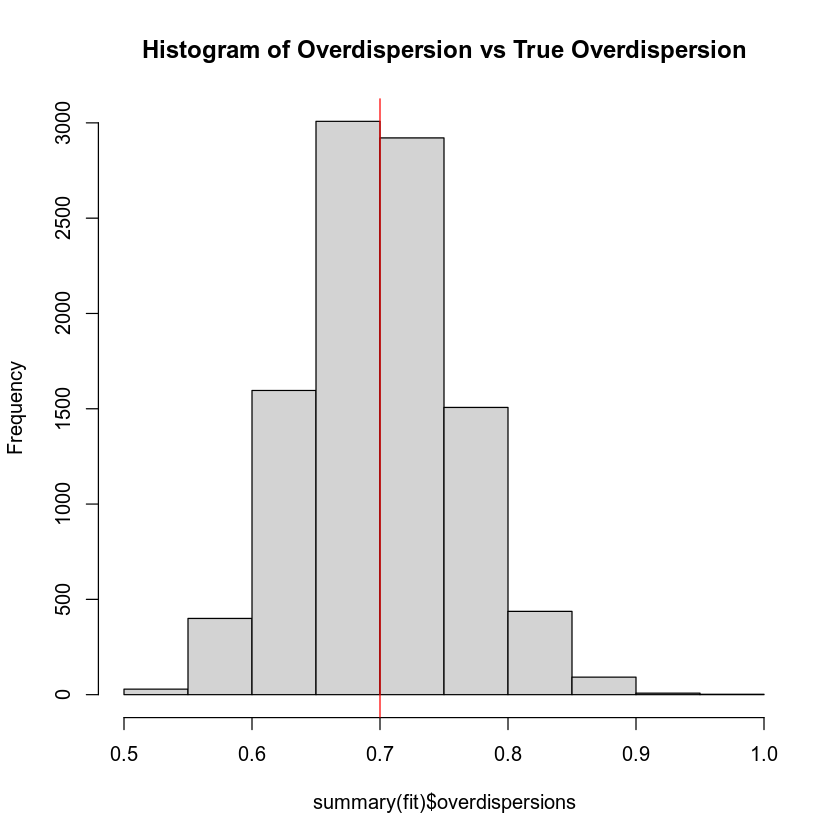

In [37]:
hist(summary(fit)$overdispersions, main = "Histogram of Overdispersion vs True Overdispersion")
abline(v=1/size, col="Red")

### Fitting glmGamPoi on Morabito Data

In [7]:
input = readRDS("/PHShome/sv433/scratch/MORABITO/RNA/RNA_counts_ct_batch.RDS")

counts = input$counts
cell_type = input$cell_type
batch = as.factor(input$batch)

dim(counts)
head(counts)
head(cell_type)

[1]  2527 60394

  [[ suppressing 34 column names ‘AAACCCAAGAAGCTCG-1’, ‘AAACCCAAGGATGCGT-1’, ‘AAACGAAGTTCGAAGG-1’ ... ]]



6 x 60394 sparse Matrix of class "dgCMatrix"
                                                                               
AL390334.1 . . . . . 2 . . . . . . . . . . . . . . . . . 4  .  . . . .  . . . .
SGCZ       . . . . . . . 3 . . . . . . . . . . . . . . . .  .  . . . .  . . . .
CARMN      . . . . . . . . . . . . . . . . . . . . . . . .  .  . . . .  . . . .
LINC01505  3 2 . . . 1 . . . . . . . . . . . . . . 5 . 1 .  .  . . . .  . . . .
AC012593.1 . 6 . 1 . . 3 1 . . . . . . . . . . . . . . 1 .  1 12 . . .  . . . .
C5orf17    . 4 3 . . . 1 6 4 . . 1 . . . . 1 . . . . . . 8 13  . 2 1 3 10 . 2 .
                   
AL390334.1 1 ......
SGCZ       . ......
CARMN      . ......
LINC01505  . ......
AC012593.1 . ......
C5orf17    . ......

 .....suppressing 60360 columns in show(); maybe adjust 'options(max.print= *, width = *)'
 ..............................

[1] "ODC" "ODC" "ODC" "ODC" "ODC" "ODC"

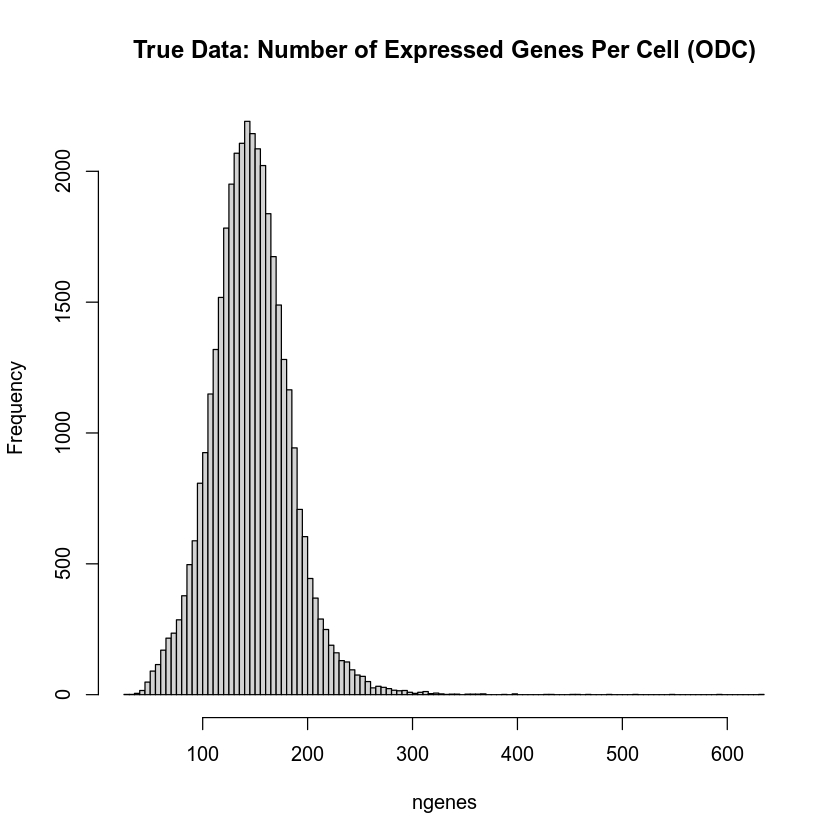

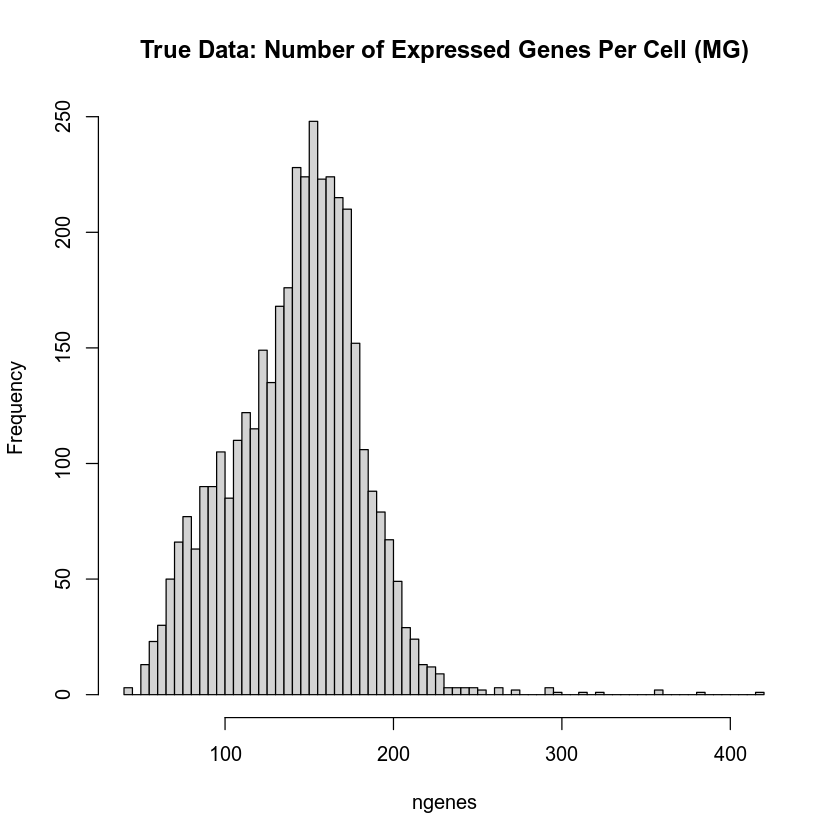

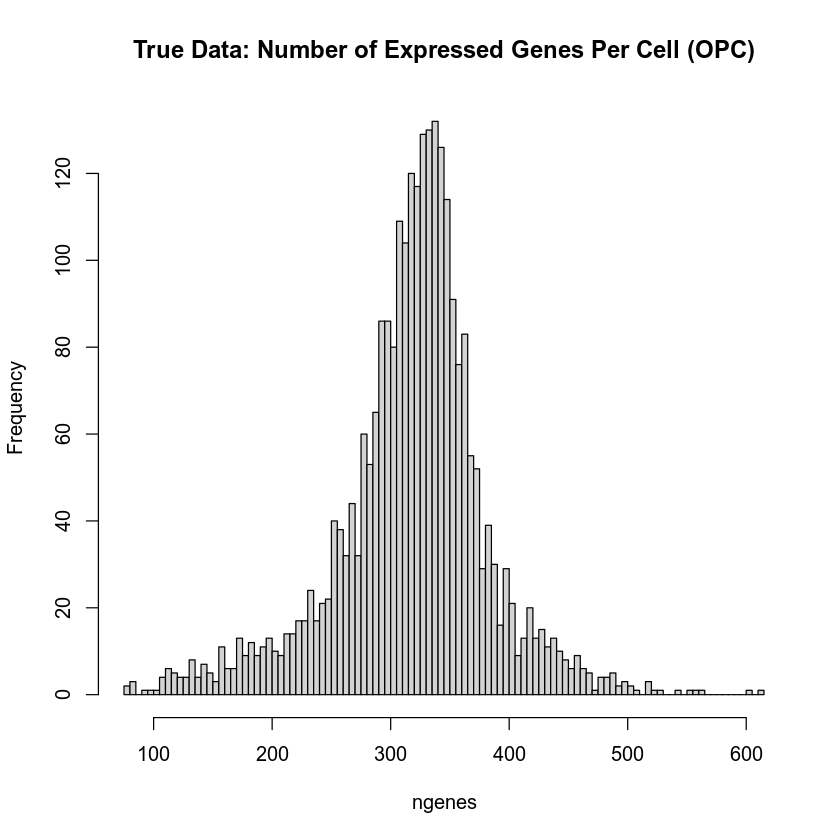

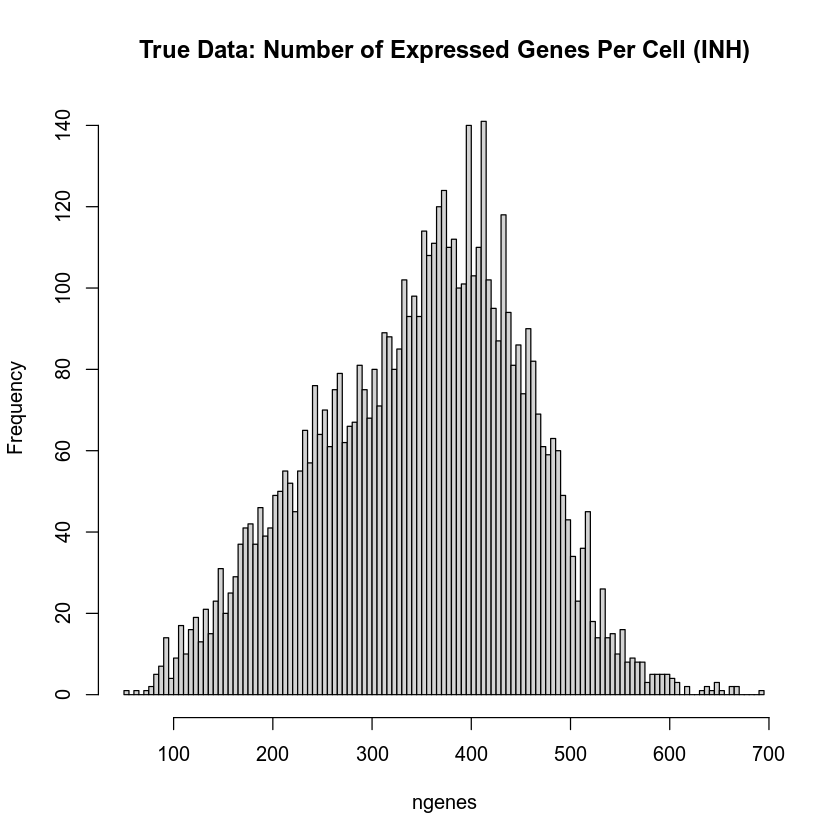

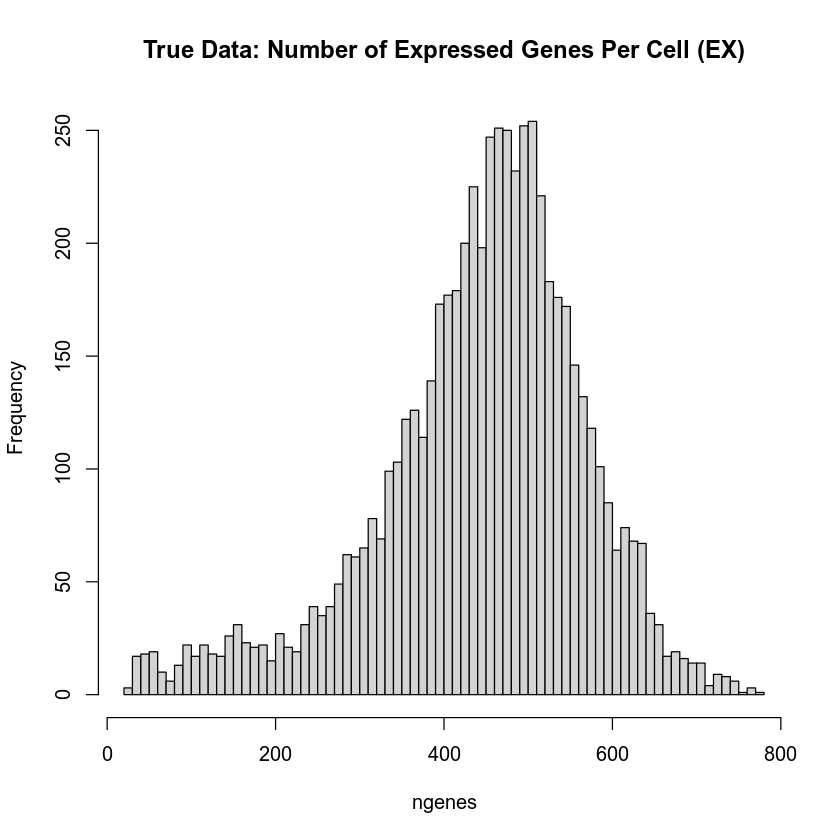

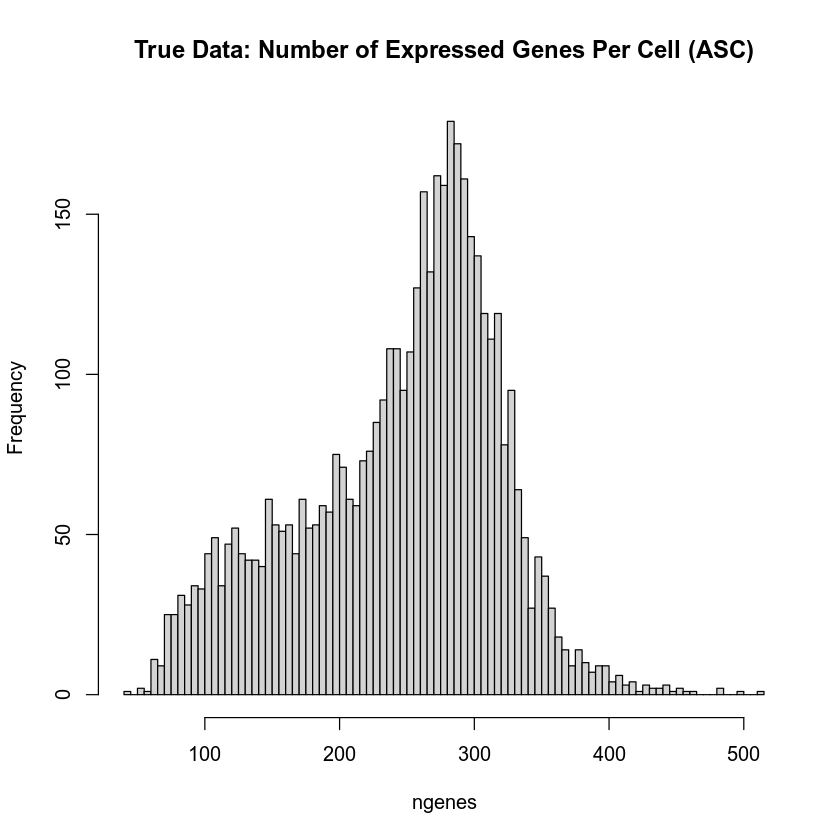

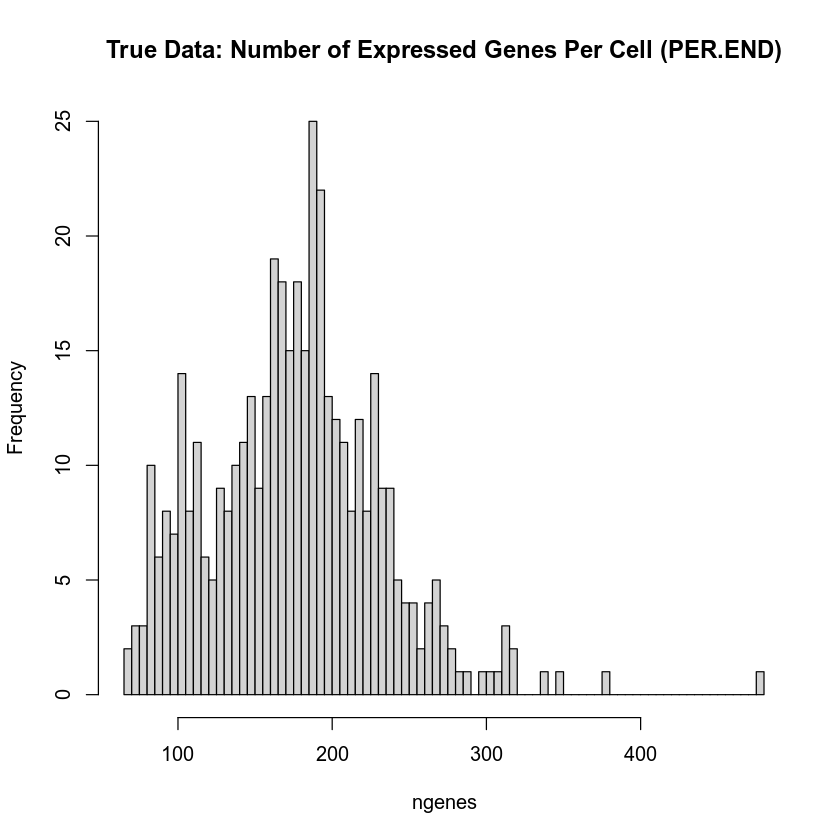

In [8]:
# filter out outliers on right tail
# plot number of expressed genes per cell

for (ct in unique(cell_type)){
    tmp_counts_ct = counts[,cell_type == ct]
    ngenes = apply( tmp_counts_ct != 0 , 2 , sum )
    hist(ngenes,breaks=100, main = glue("True Data: Number of Expressed Genes Per Cell ({ct})") )    
}


In [ ]:
# construct matrix for overdispersion and Mus to populate
overdispersion = matrix(, nrow = dim(counts)[1], ncol = length(unique(cell_type)))
rownames(overdispersion) = rownames(counts)
colnames(overdispersion) = unique(cell_type)
Mu = overdispersion

# fit Mu and overdispersion parameters for cell type
for (ct in unique(cell_type)){
    
    # subset by cell type
    sub_ct = counts[,cell_type == ct]  
    
    # fit the gamma-poisson and extract fitted parameters
    # fitting without batch
    fit <- glm_gp(sub_ct, design = ~ 1, on_disk = FALSE)
    
    # fitting with batch
    #fit <- glm_gp(sub_ct, design = batch[cell_type == ct], on_disk = FALSE)
    
    # summary(fit)
    overdispersion_ct = summary(fit)$overdispersions
    Mu_ct = rowMeans(summary(fit)$Mu)
    
    # input parameters into matrices for all cell types
    overdispersion[,ct] = overdispersion_ct
    Mu[,ct] = Mu_ct
    
}

output = x <- list("overdispersion" = overdispersion, "Mu" = Mu)
saveRDS(output, "/PHShome/sv433/scratch/MORABITO/RNA/fitted_parameters_Gamma_poiss.RDS")

### Simulate from model fitted to Morabito data

In [9]:
output = readRDS("/PHShome/sv433/scratch/MORABITO/RNA/fitted_parameters_Gamma_poiss.RDS")
overdispersion = output$overdispersion
Mus = output$Mu

set.seed(9)

In [10]:
# simulate dataset the size of Morabito data
head(Mus)
head(overdispersion)


,ODC,MG,OPC,INH,EX,ASC,PER.END
AL390334.1,0.199490794,0.007872656,5.327984e-01,0.118755547,0.18708942,0.1632426090,0.02166994
SGCZ,0.486193068,0.058905933,1.675683e+01,35.056652809,8.13335974,0.3057546540,0.11203240
CARMN,0.003999313,0.002821236,7.401925e-04,0.003376762,0.00482436,0.0006570066,1.49282741
LINC01505,1.930223794,0.150392670,2.107826e+00,1.454126365,1.42031792,0.3482335540,0.23988523
AC012593.1,3.241993084,0.046172764,1.848567e+00,0.751253572,0.27619006,1.8030442367,0.14808557
C5orf17,0.281033190,0.345962531,3.970099e-01,0.255754142,0.63825879,0.2719866707,0.32576695


,ODC,MG,OPC,INH,EX,ASC,PER.END
AL390334.1,98.321422,39.59560,17.432739,9.435760,4.535476,13.387407,5.158775e-06
SGCZ,34.374850,13.87971,1.525686,3.243682,8.126543,13.357750,3.094878e+01
CARMN,1297.168109,71.63500,0.000000,270.308891,59.737658,308.553703,4.332602e+00
LINC01505,5.094138,27.94346,4.048187,3.889142,4.970169,10.958197,2.297725e+01
AC012593.1,2.384491,16.33688,5.634984,15.420936,21.516489,3.145935,4.449167e+01
C5orf17,38.208422,20.96482,33.225130,36.958023,22.085455,27.573940,3.938446e+01


In [11]:
sample_Gamma_Pois <- function(ct){
    # create empty dataframe to populate with cell sample
    cell_sample = as.matrix(rep(NA, dim(Mus)[1]) )
    rownames(cell_sample) = rownames(Mus)

    # iterate over each gene
    for (i in rownames(Mus) ){

        # select mu based on gene i and ct
        tmp_mu = Mus[,ct][[i]]

        # select overdispersion based on gene i and ct
        tmp_disp = overdispersion[,ct][[i]]
  
        # check that the overdispersion is non-zero... if zero, Nbinom degernates to a poisson
            # if alpha = 0, the Gamma-Poisson reduces to a Poisson with mean mu
        if (tmp_disp != 0){
            sample = rnbinom(n = 1, mu = tmp_mu, size = 1/tmp_disp) 

        } else {
            sample = rpois(n = 1, lambda = tmp_mu)

        }

        cell_sample[i,] = sample

    }
    return(cell_sample)    
}


In [12]:
table(cell_type)

cell_type
    ASC      EX     INH      MG     ODC     OPC PER.END 
   4573    6042    5853    3899   36898    2702     427 

In [13]:
# simulate 427 of each cell type (only 427 Per.End)
size = 427
ct_sim = rep(unique(cell_type), each=size)

In [14]:
# simulating only the first 10k cells 
sim_exp <- do.call(cbind, lapply(ct_sim, FUN=sample_Gamma_Pois) )


In [15]:
# sample random indices of real data to match simulated data
indices = c()
for (ct in unique(cell_type)){
    ind_ct = sample(which(cell_type == ct), size = size, replace = FALSE) 
    indices = c(indices, ind_ct)
    
}
# obtain true expression subsampled
ct_true = cell_type[indices]
true_exp = counts[,indices]

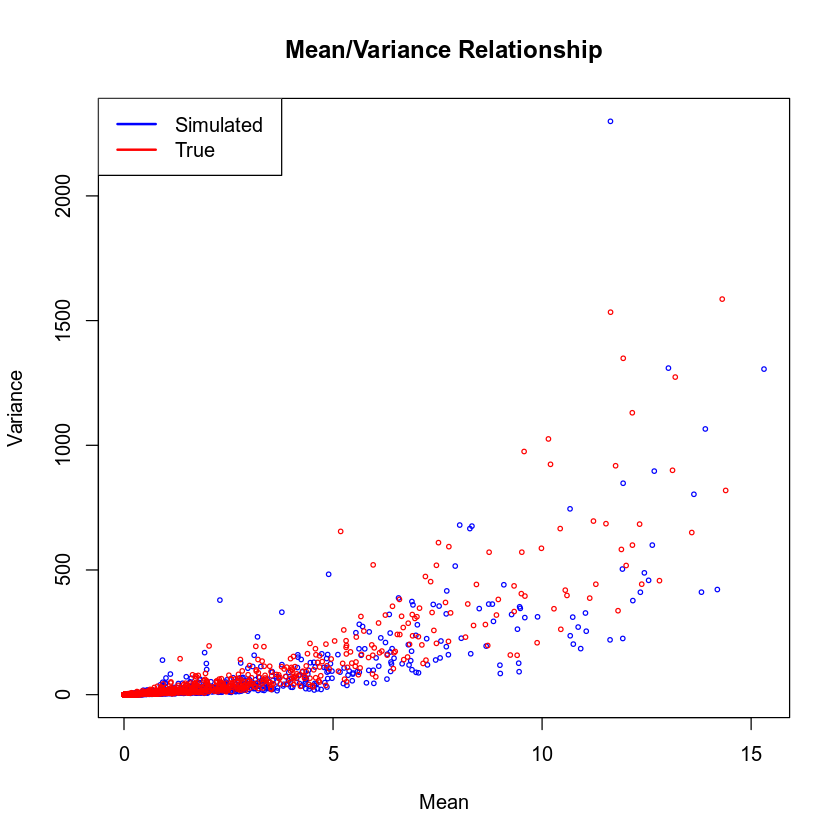

In [31]:
mus = apply( sim_exp , 1 , mean )
sds = apply( sim_exp , 1 , sd )
plot( mus , sds^2 , xlab="Mean" , ylab="Variance" , cex=0.5, main = "Mean/Variance Relationship", col="blue" )

mus = apply( true_exp , 1 , mean )
sds = apply( true_exp , 1 , sd )
points( mus , sds^2 , xlab="Mean" , ylab="Variance" , cex=0.5, main = "Mean/Variance Relationship", col="red")
legend(x = "topleft",          # Position
       legend = c("Simulated", "True"), 
       lty = c(1, 1),           # Line types
       col = c("blue", "red"),           # Line colors
       lwd = 2)   

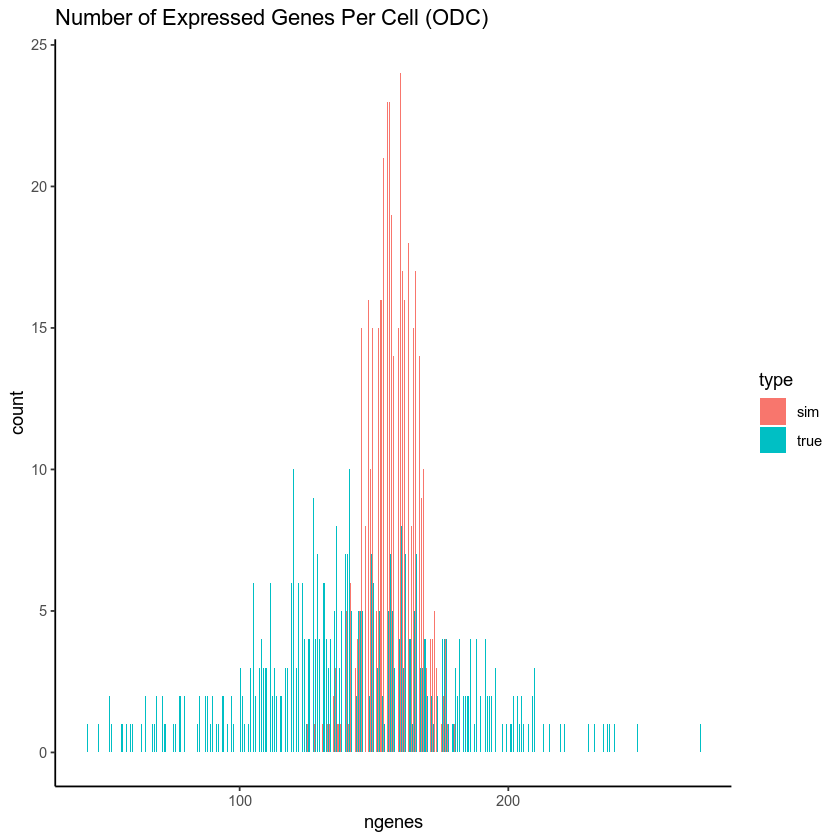

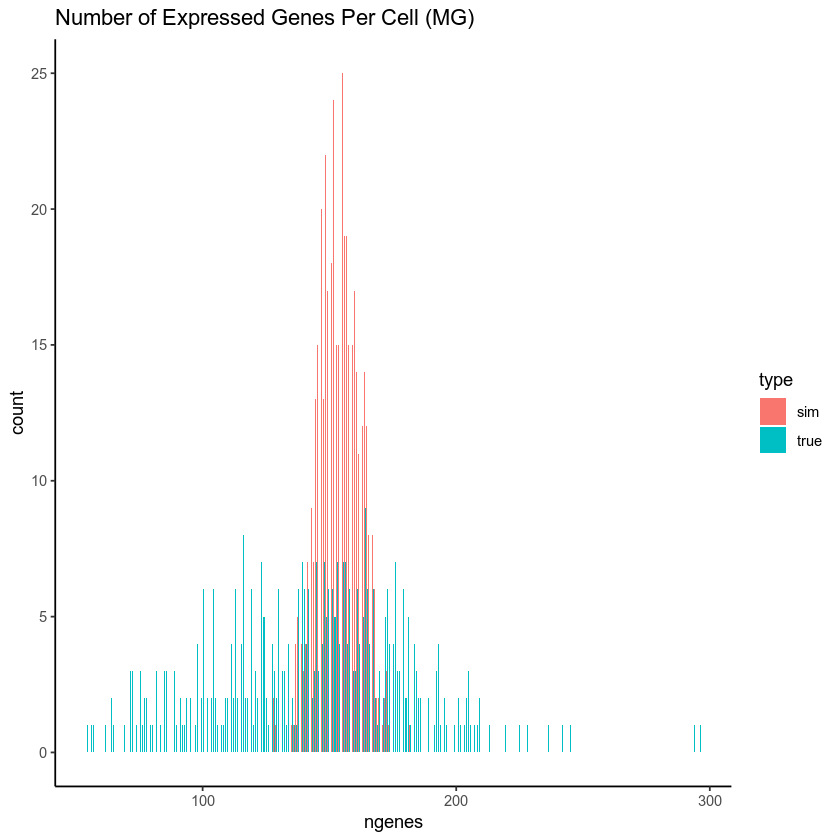

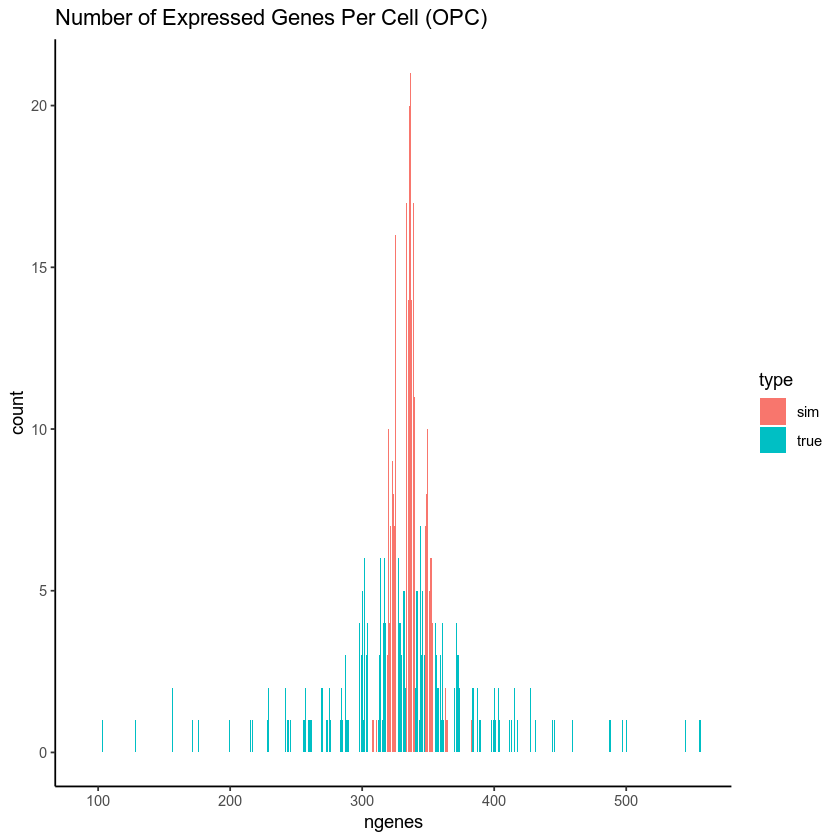

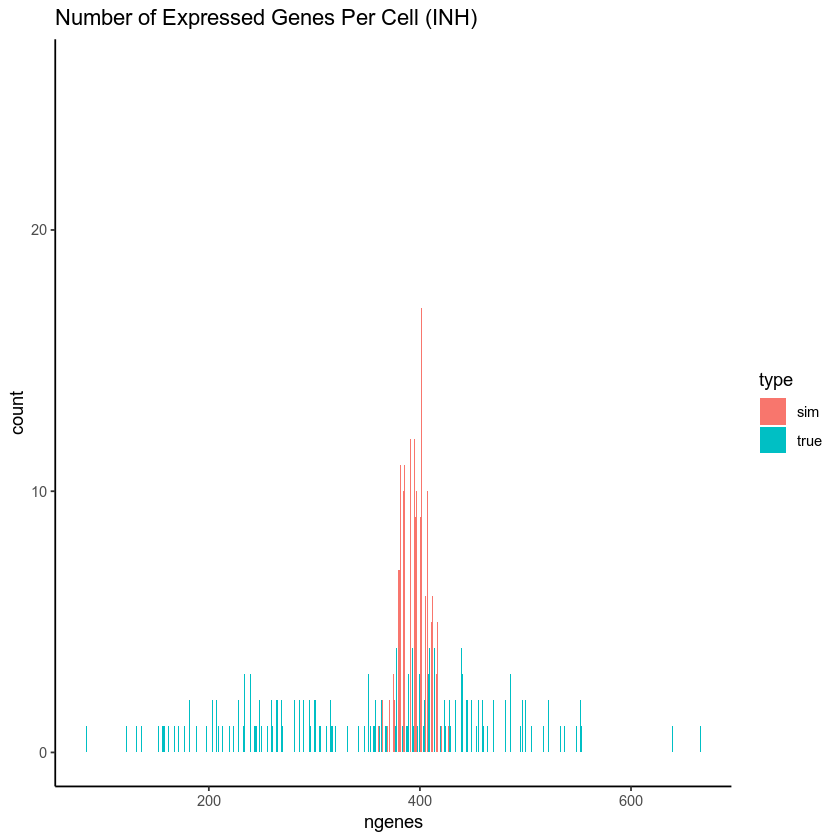

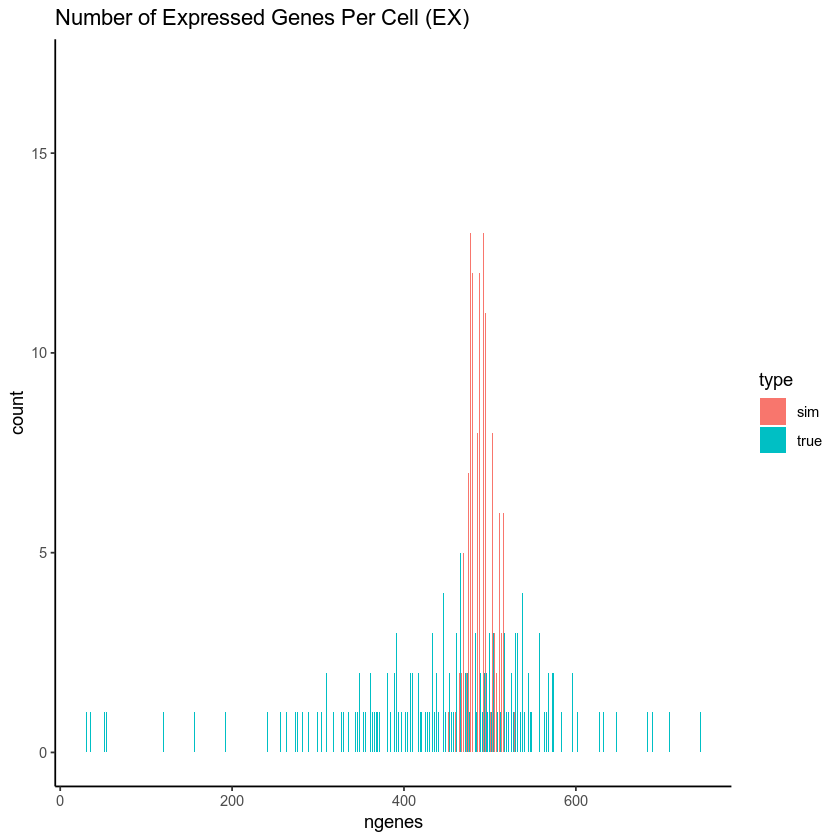

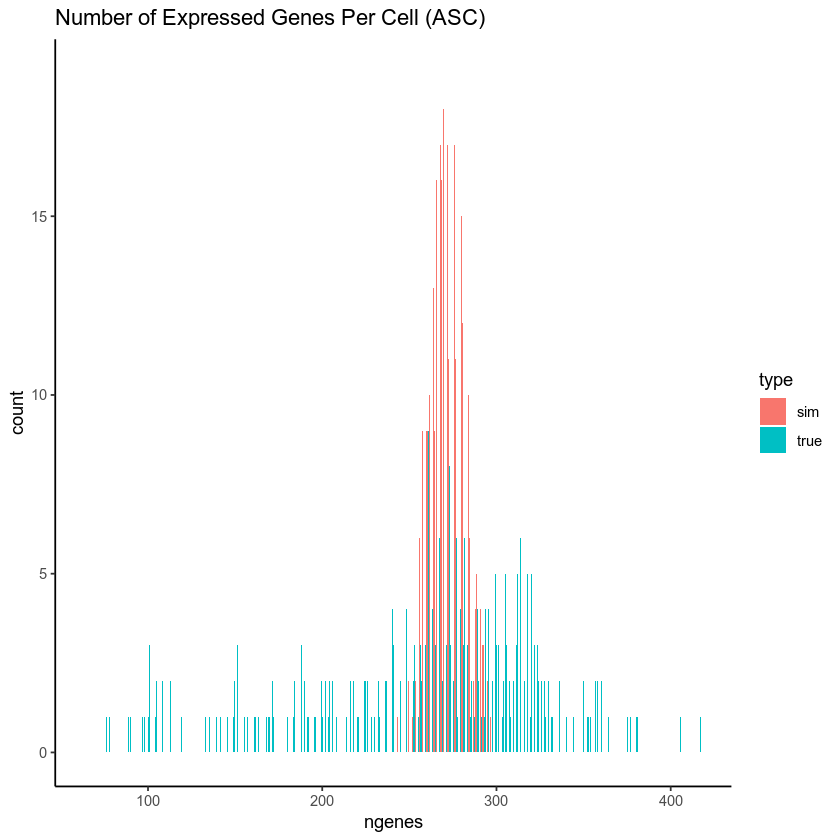

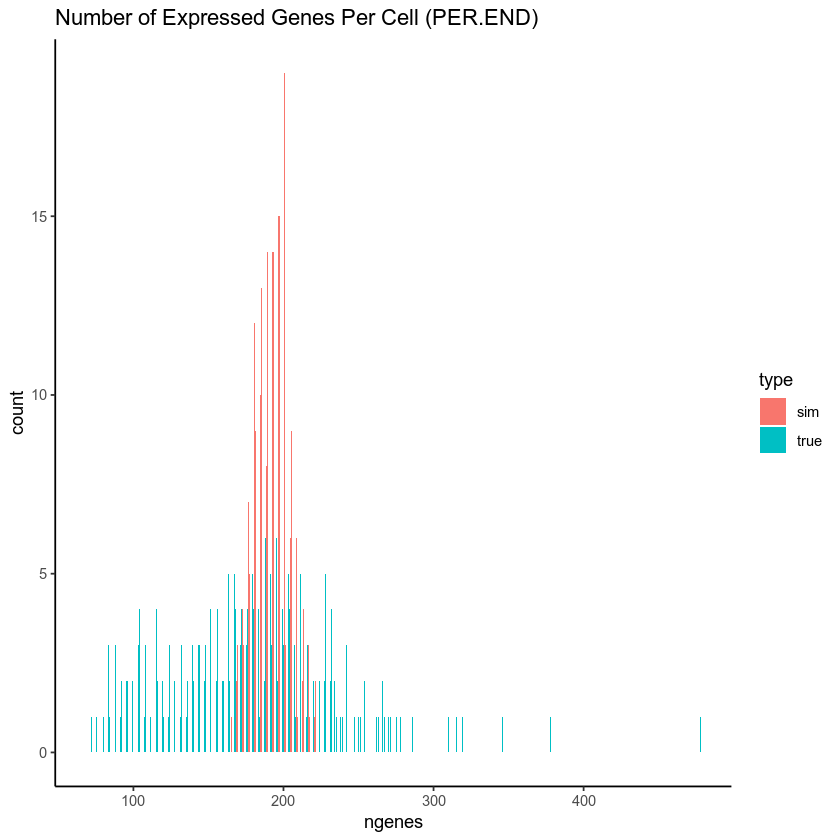

In [18]:
for (ct in unique(cell_type)){
    # plot number of expressed genes per cell
    tmp_counts_ct = sim_exp[,ct_sim == ct]
    ngenes = apply( tmp_counts_ct != 0 , 2 , sum )
    #hist(ngenes,breaks=100, main = glue("Simulated: Number of Expressed Genes Per Cell ({ct})") ) 
    tmp_counts_ct = sim_exp[,ct_sim == ct]
    ngenes = apply( tmp_counts_ct != 0 , 2 , sum )
    df = data.frame(ngenes)
    df$type = "sim"
    
    # plot number of expressed genes per cell
    tmp_counts_ct = true_exp[,ct_true == ct]
    ngenes = apply( tmp_counts_ct != 0 , 2 , sum )
    #hist(ngenes,breaks=100, main = glue("Simulated: Number of Expressed Genes Per Cell ({ct})") ) 
    df_tmp = data.frame(ngenes)
    df_tmp$type = "true"
    
    df = rbind(df, df_tmp)
    
    p = ggplot(df, aes(ngenes, fill = type)) + geom_histogram(position = "dodge",binwidth = 0.8) + ggtitle(label = glue("Number of Expressed Genes Per Cell ({ct})") ) + theme_classic()
    print(p)

}


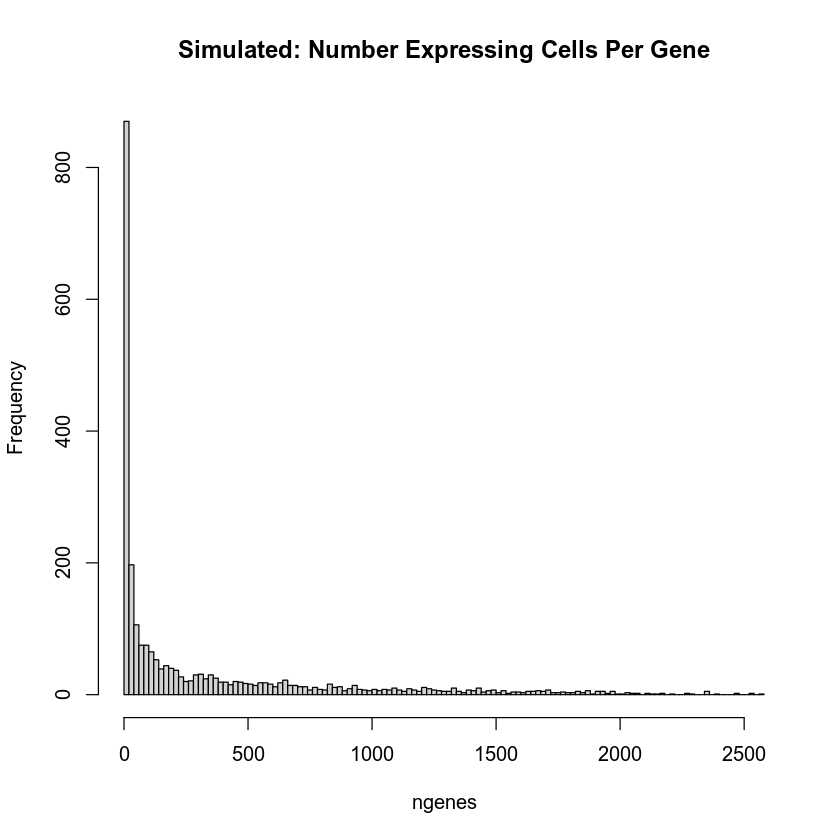

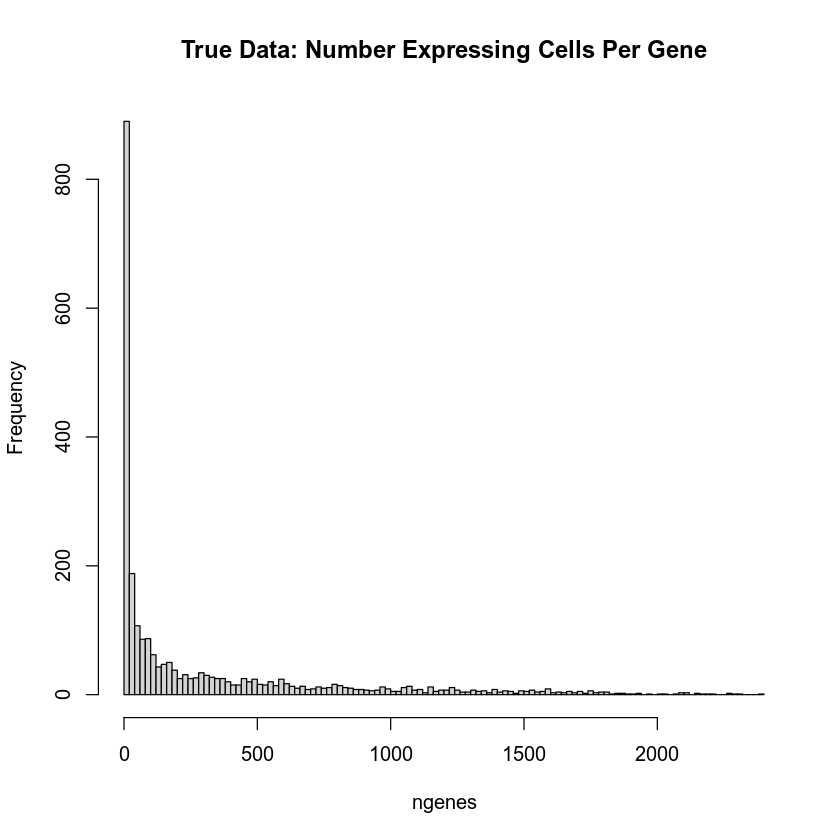

In [19]:
# plot number of expressed cells per gene
ngenes = apply( sim_exp != 0 , 1 , sum )
hist(ngenes,breaks=100, main = "Simulated: Number Expressing Cells Per Gene")

# plot number of expressed cells per gene
ngenes = apply( true_exp != 0 , 1 , sum )
hist(ngenes,breaks=100, main = "True Data: Number Expressing Cells Per Gene")

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 90 features requested have zero variance (running reduction without them): OR2A5, ELANE, C1orf50, AP003031.1, AC005840.3, LINC00375, HNRNPUL2, PRAME, AC114928.1, AC011451.2, AC018980.1, LINC00160, AC005972.1, RPL9P18, PAX9, CHIAP2, LINC00395, RPS20P31, LINC00851, AC112187.3, RPS4XP22, AP005242.3, AL136097.1, AC105339.5, BNIP3P10, AC103808.4, RPS14P8, AC005020.1, IKBKGP1, BNIP3P19, OR7E29P, IMPDH1P5, CCER1, RPL9P2, KU-MEL-3, OR6C2, DNAJC19P1, AC106760.2, SULT1A4, AC078850.1, FAM213AP2, RN7SL18P, BPIFA3, AL590128.1, Z99755.2, FOXN1, AC024940.2, AL121757.2, SPTA1, BLK, FCN1, AHSP, AC008121.1, HSPA8P6, IFNG, FAM91A3P, CTSW, AC093010.2, HIST1H2BK, AC137834.2, HIST2H2AB, CCL8, S100A11P1, LINC00550, RBBP4P4, AP003117.2, AC134682.1, OR12D1, AL591721.1, LINC00583, LINC00378, RPS4XP19, SCGB3A1, AC135776.4, AC015977.1, OTX2, AL512604.3, IGLCOR22-2, RAB28P3, AC06083

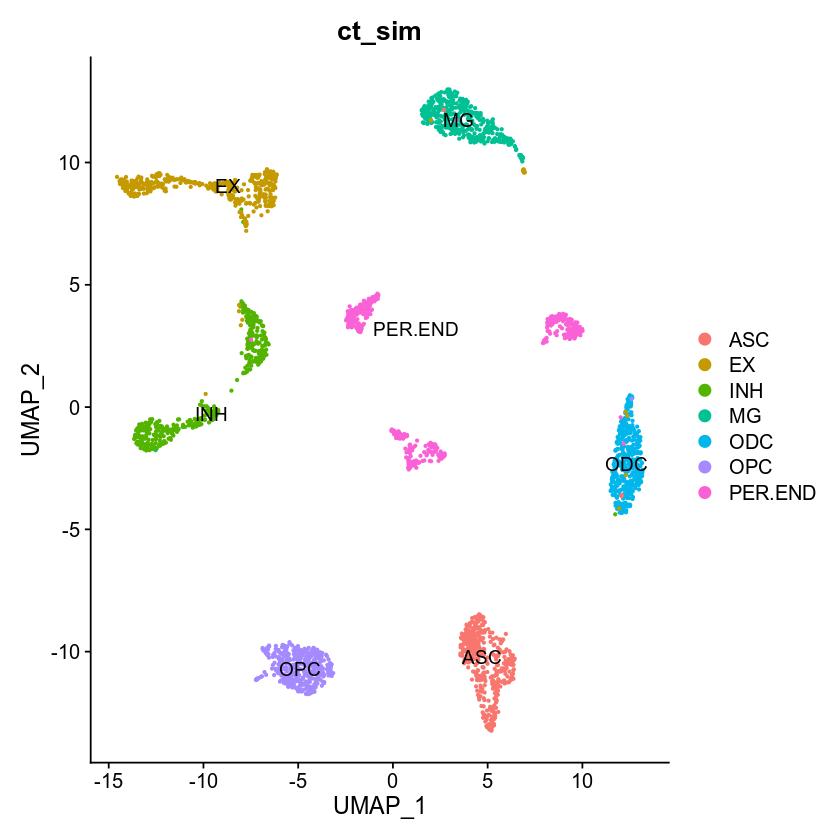

In [372]:
# create umap for true data
sim_exp_seu = CreateSeuratObject(true_exp)
# colnames(sim_exp) = paste0("cell", 1:dim(sim_exp)[2])
# sim_exp_seu = CreateSeuratObject(sim_exp)

ct = data.frame(ct_sim)
rownames(ct) = colnames(sim_exp_seu)
sim_exp_seu <- AddMetaData(sim_exp_seu, ct, col.name = NULL)
sim_exp_seu <- NormalizeData(sim_exp_seu, normalization.method = "LogNormalize", scale.factor = 10000)
all.genes <- rownames(sim_exp_seu)
sim_exp_seu <- ScaleData(sim_exp_seu, features = all.genes)
sim_exp_seu <- RunPCA(sim_exp_seu, features = all.genes)
sim_exp_seu <- RunUMAP(sim_exp_seu, dims = 1:10)
DimPlot(sim_exp_seu, reduction = "umap", label=T, group.by="ct_sim")

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 104 features requested have zero variance (running reduction without them): CNFN, LINC01913, AP003031.1, AC005840.3, LINC00375, HNRNPUL2, AC091182.1, RPL12P37, AC114928.1, AP000925.1, AC018980.1, LINC00160, AC005972.1, PAX9, CHIAP2, RPS20P31, AL139193.2, LINC00851, PPIAP25, RPS4XP22, AP005209.1, AP005242.3, AC108693.2, SAA3P, OPN1LW, AL136097.1, BNIP3P10, AC103808.4, RPS14P8, AC005020.1, IKBKGP1, CALHM3, ICE2P1, VPS35P1, BNIP3P19, OR7E29P, IMPDH1P5, CCER1, RPL9P2, KU-MEL-3, OR6C2, AL161908.1, AC087343.1, AC078850.1, RN7SL18P, BPIFA3, AL590128.1, Z99755.2, AL358176.3, FOXN1, AC024940.2, AL121757.2, TSPO2, FCN1, AHSP, CXCL8, CCR7, IFNG, FAM91A3P, CTSW, HIST1H2BK, CD3D, AC137834.2, ZNF683, CCL8, AL513343.1, S100A11P1, AC074033.1, LINC00550, AP001062.2, AVP, AC092368.1, OR12D1, AL645937.2, LRRC37A9P, LINC00583, RPS4XP19, SCGB3A1, NOBOX, AC135776.4, AL049714.

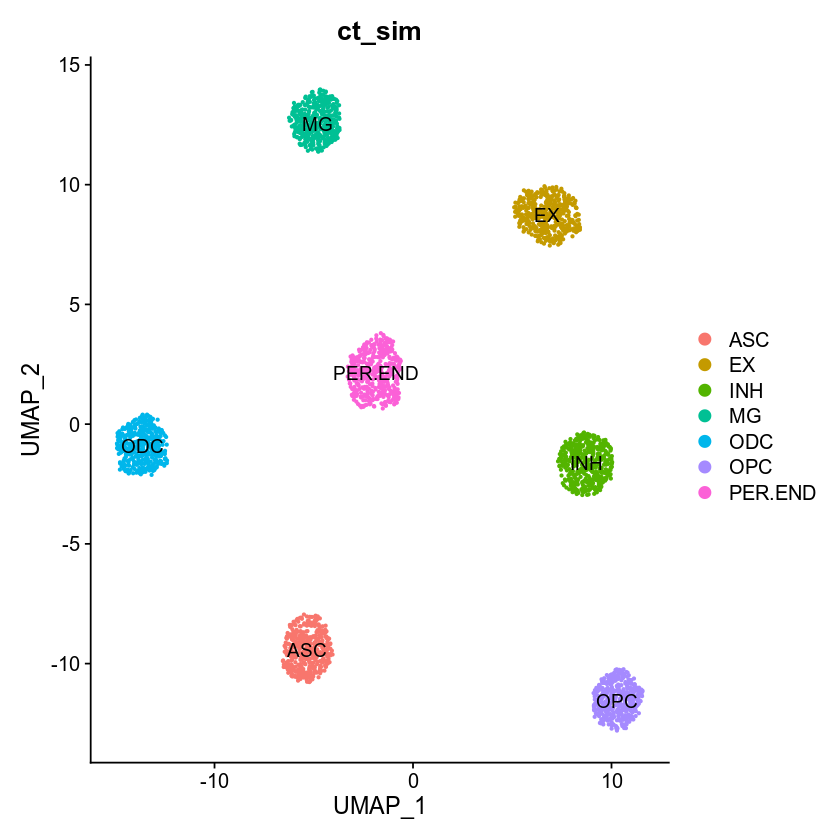

In [371]:
# create umap for simulated data
colnames(sim_exp) = paste0("cell", 1:dim(sim_exp)[2])
sim_exp_seu = CreateSeuratObject(sim_exp)

ct = data.frame(ct_sim)
rownames(ct) = colnames(sim_exp_seu)
sim_exp_seu <- AddMetaData(sim_exp_seu, ct, col.name = NULL)
sim_exp_seu <- NormalizeData(sim_exp_seu, normalization.method = "LogNormalize", scale.factor = 10000)
all.genes <- rownames(sim_exp_seu)
sim_exp_seu <- ScaleData(sim_exp_seu, features = all.genes)
sim_exp_seu <- RunPCA(sim_exp_seu, features = all.genes)
sim_exp_seu <- RunUMAP(sim_exp_seu, dims = 1:10)
DimPlot(sim_exp_seu, reduction = "umap", label=T, group.by="ct_sim")

### Random genes selected to fit simulation

In [20]:
rand_counts = readRDS("/PHShome/sv433/scratch/MORABITO/RNA/RNA_counts_random_batch.RDS")

counts = rand_counts$counts
cell_type = rand_counts$cell_type
batch = as.factor(rand_counts$batch)

dim(counts)
head(counts)
head(cell_type)

[1]  2527 61472

  [[ suppressing 34 column names ‘AAACCCAAGAAGCTCG-1’, ‘AAACCCAAGGATGCGT-1’, ‘AAACGAAGTTCGAAGG-1’ ... ]]



6 x 61472 sparse Matrix of class "dgCMatrix"
                                                                               
GOLGA8A     1 . . . . 1 . . . . . 1 . . . . . . . . . . 1 . 1 . . . . . . . . .
CCL5        . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
OSBPL10-AS1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
AL645730.1  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
AC138811.2  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
NANOS2      . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
                  
GOLGA8A     ......
CCL5        ......
OSBPL10-AS1 ......
AL645730.1  ......
AC138811.2  ......
NANOS2      ......

 .....suppressing 61438 columns in show(); maybe adjust 'options(max.print= *, width = *)'
 ..............................

[1] ODC ODC ODC ODC ODC ODC
Levels: ASC EX INH MG ODC OPC PER.END

In [21]:
# construct matrix for overdispersion and Mus to populate
overdispersion = matrix(, nrow = dim(counts)[1], ncol = length(unique(cell_type)))
rownames(overdispersion) = rownames(counts)
colnames(overdispersion) = unique(cell_type)
Mu = overdispersion

# fit Mu and overdispersion parameters for cell type
for (ct in unique(cell_type)){
    
    # subset by cell type
    sub_ct = counts[,cell_type == ct]  
    
    # fit the gamma-poisson and extract fitted parameters
    # fitting without batch
    fit <- glm_gp(sub_ct, design = ~ 1, on_disk = FALSE)
    
    # fitting with batch
    #fit <- glm_gp(sub_ct, design = batch[cell_type == ct], on_disk = FALSE)
    
    # summary(fit)
    overdispersion_ct = summary(fit)$overdispersions
    Mu_ct = rowMeans(summary(fit)$Mu)
    
    # input parameters into matrices for all cell types
    overdispersion[,ct] = overdispersion_ct
    Mu[,ct] = Mu_ct
    
}

Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE.”
Warning message:
“useNames =

In [22]:
Mus = Mu

In [23]:
# simulating only the first 10k cells 
sim_exp <- do.call(cbind, lapply(ct_sim, FUN=sample_Gamma_Pois) )

In [24]:
# simulate 427 of each cell type (only 427 Per.End)
size = 427
ct_sim = rep(unique(cell_type), each=size)

In [25]:
# sample random indices of real data to match simulated data
indices = c()
for (ct in unique(cell_type)){
    ind_ct = sample(which(cell_type == ct), size = size, replace = FALSE) 
    indices = c(indices, ind_ct)
    
}
# obtain true expression subsampled
ct_true = cell_type[indices]
true_exp = counts[,indices]

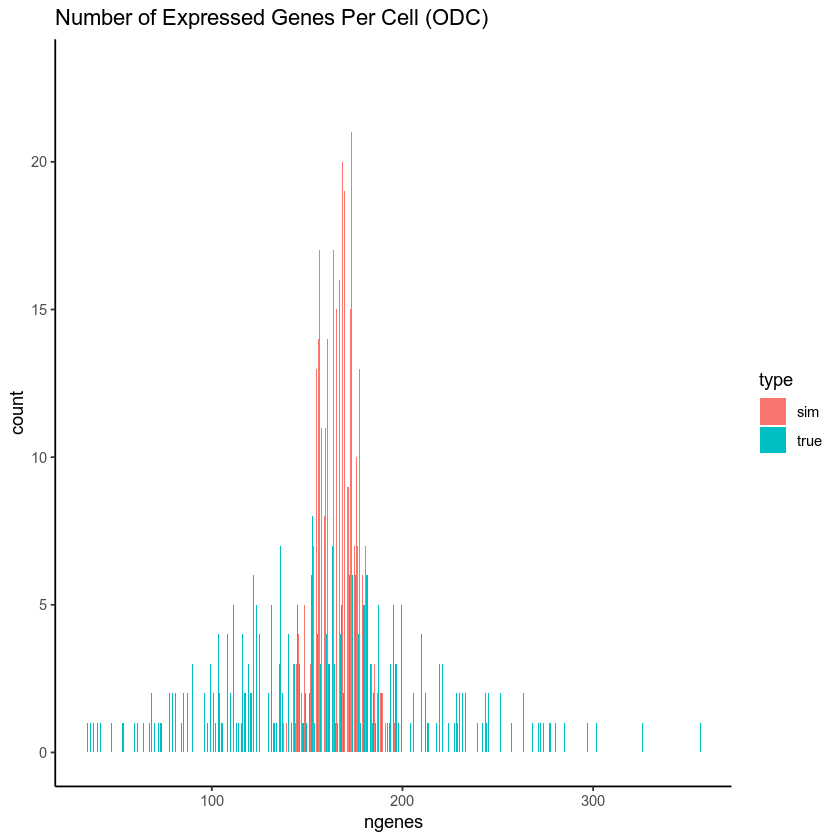

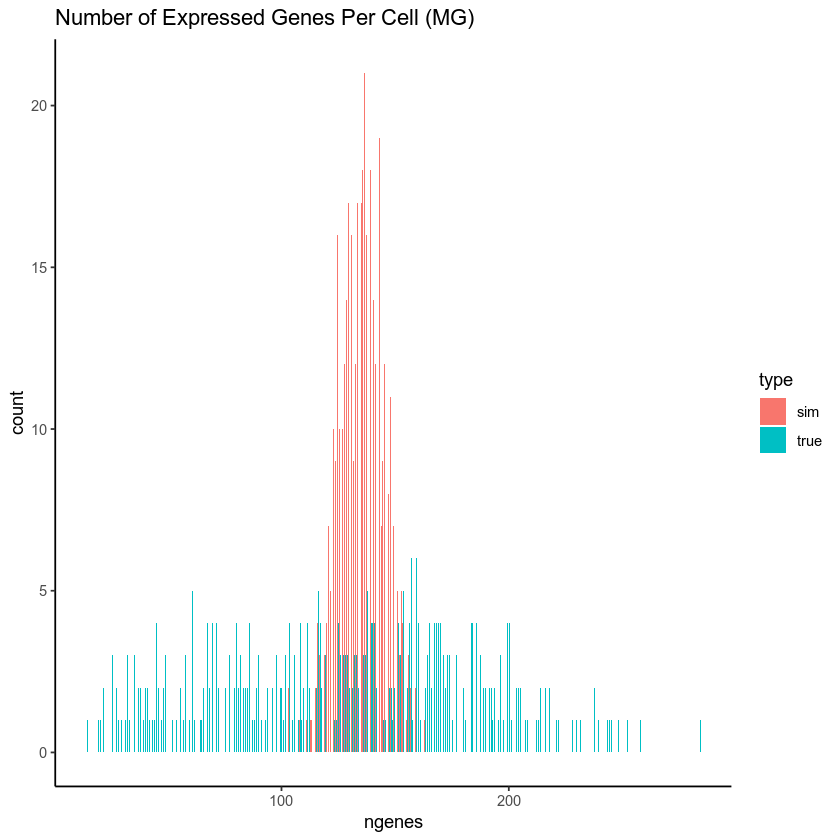

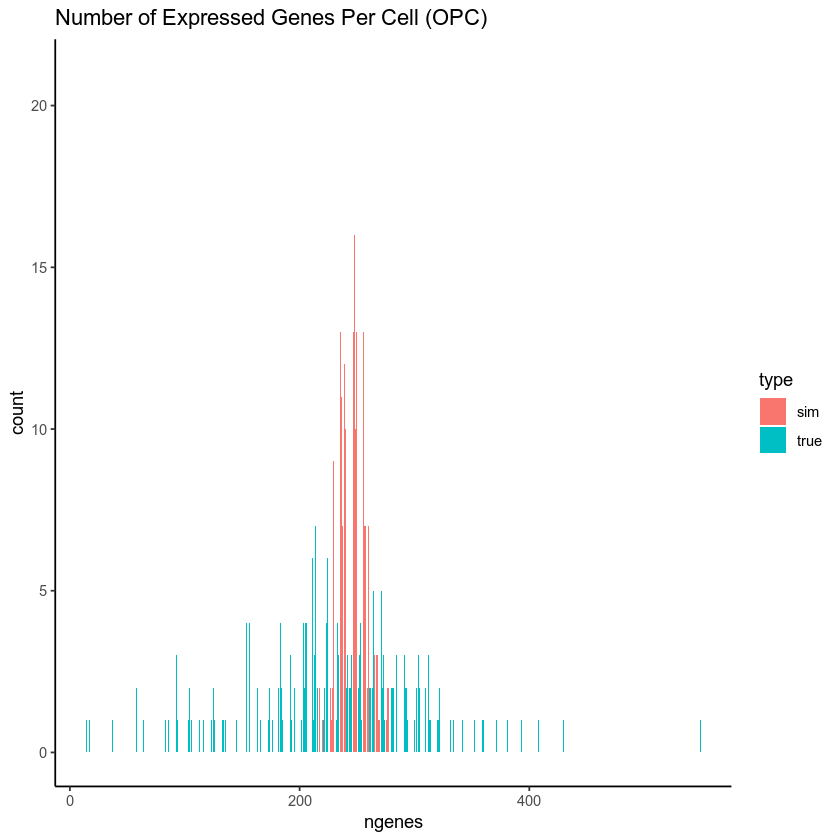

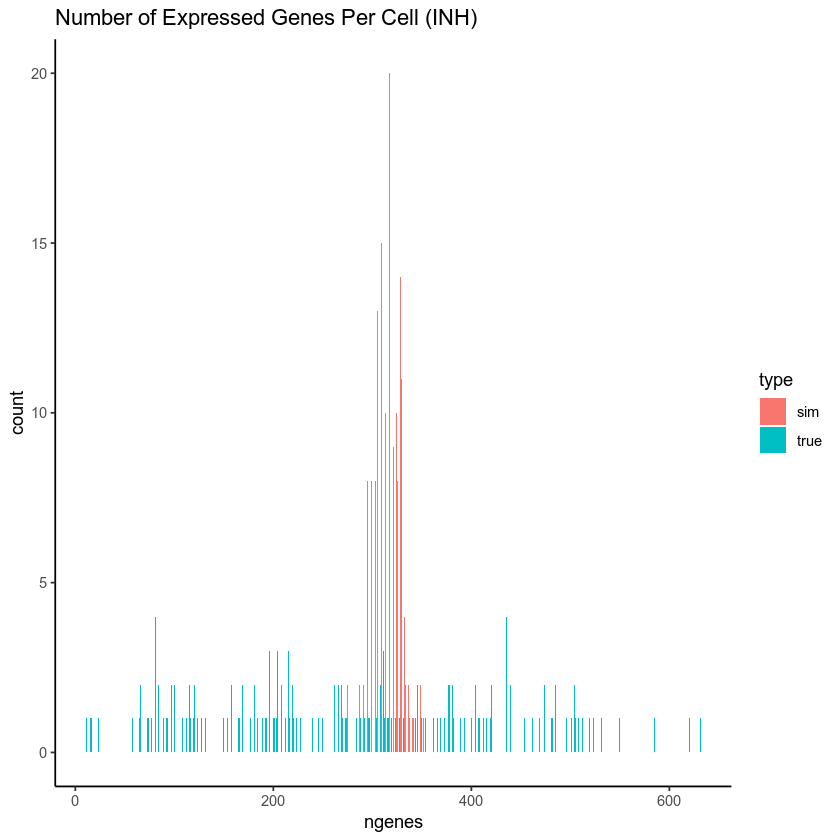

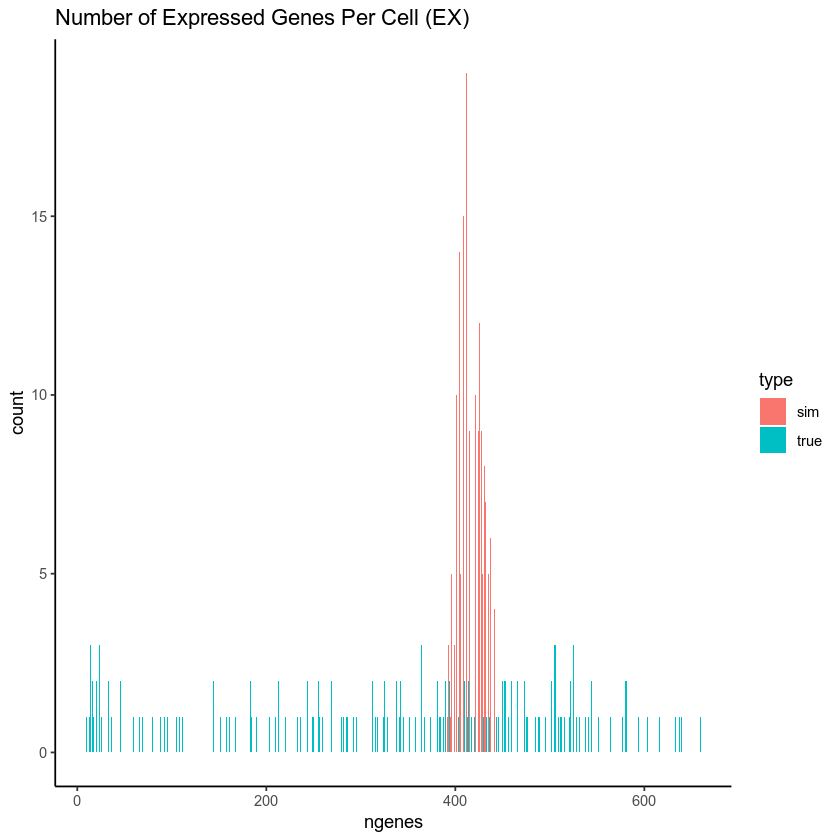

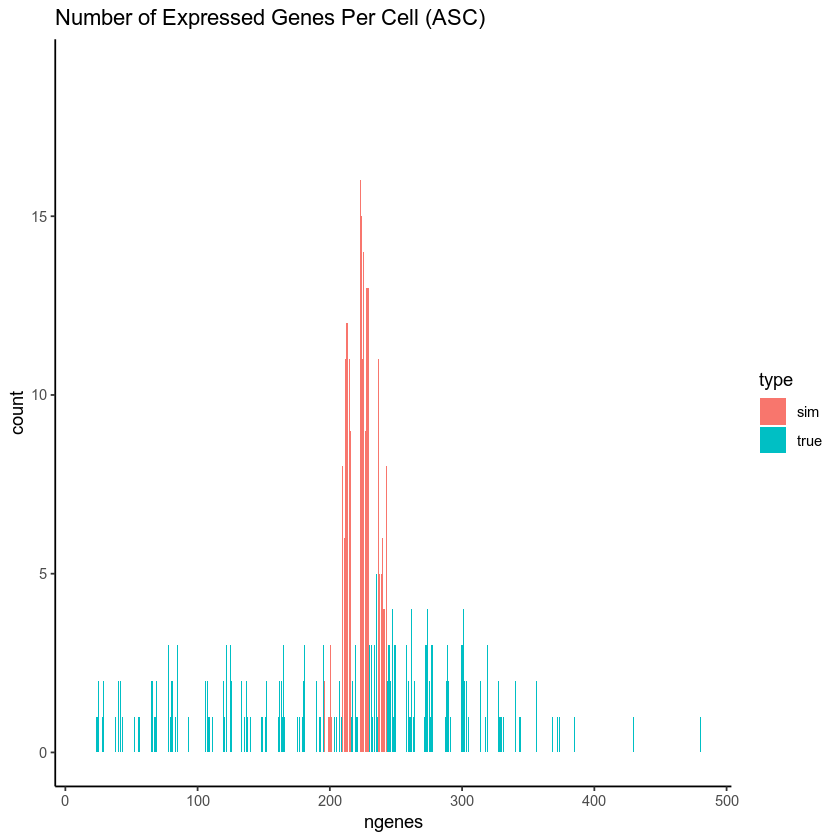

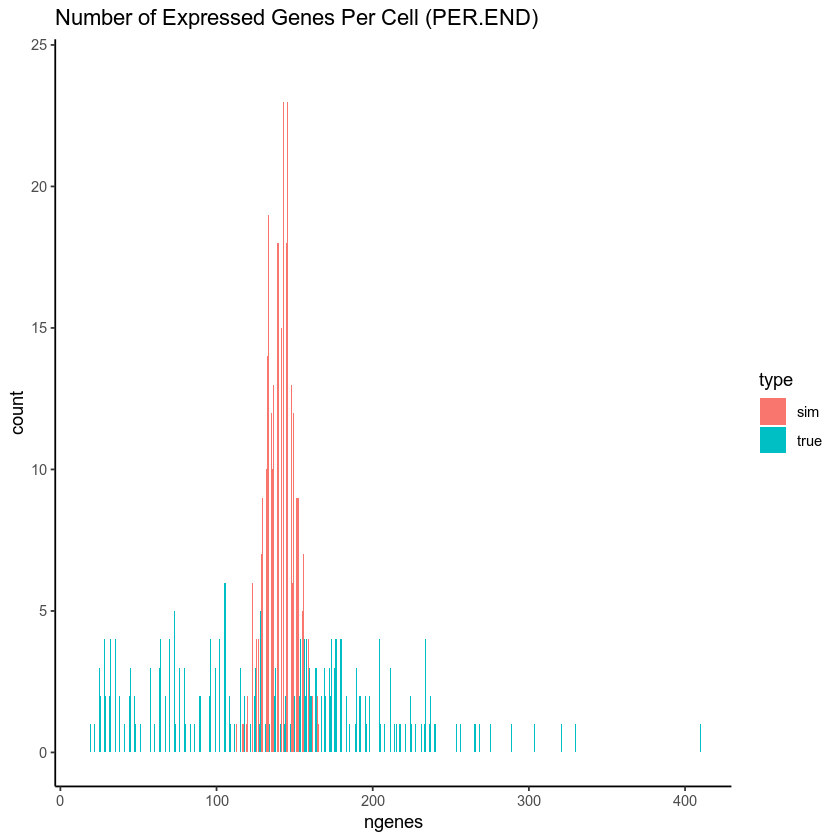

In [26]:
for (ct in unique(cell_type)){
    # plot number of expressed genes per cell
    tmp_counts_ct = sim_exp[,ct_sim == ct]
    ngenes = apply( tmp_counts_ct != 0 , 2 , sum )
    #hist(ngenes,breaks=100, main = glue("Simulated: Number of Expressed Genes Per Cell ({ct})") ) 
    tmp_counts_ct = sim_exp[,ct_sim == ct]
    ngenes = apply( tmp_counts_ct != 0 , 2 , sum )
    df = data.frame(ngenes)
    df$type = "sim"
    
    # plot number of expressed genes per cell
    tmp_counts_ct = true_exp[,ct_true == ct]
    ngenes = apply( tmp_counts_ct != 0 , 2 , sum )
    #hist(ngenes,breaks=100, main = glue("Simulated: Number of Expressed Genes Per Cell ({ct})") ) 
    df_tmp = data.frame(ngenes)
    df_tmp$type = "true"
    
    df = rbind(df, df_tmp)
    
    p = ggplot(df, aes(ngenes, fill = type)) + geom_histogram(position = "dodge",binwidth = 0.8) + ggtitle(label = glue("Number of Expressed Genes Per Cell ({ct})") ) + theme_classic()
    print(p)

}

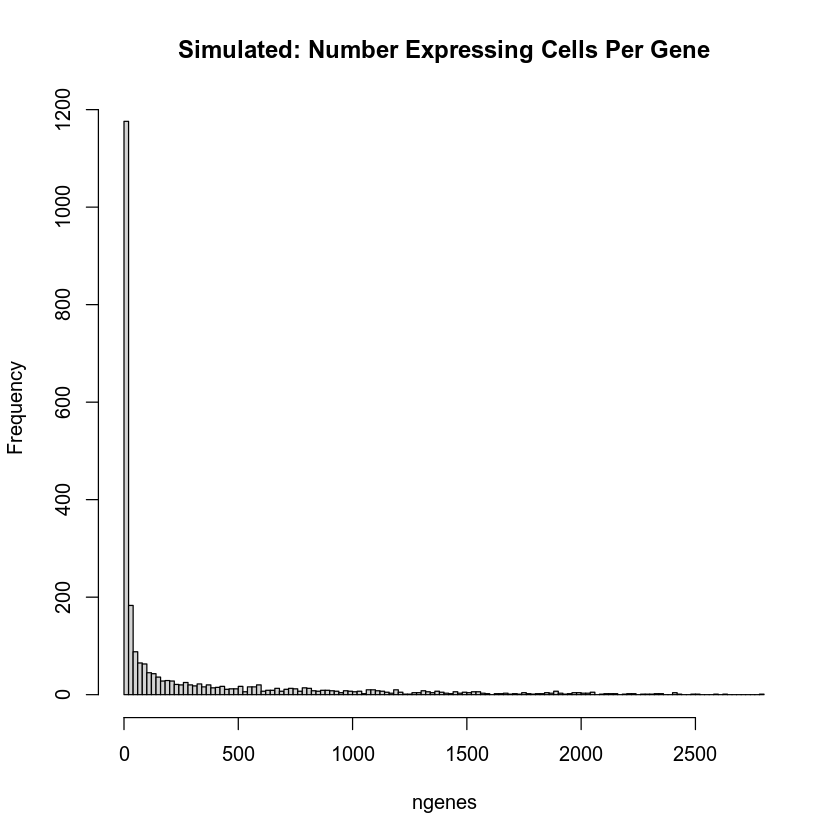

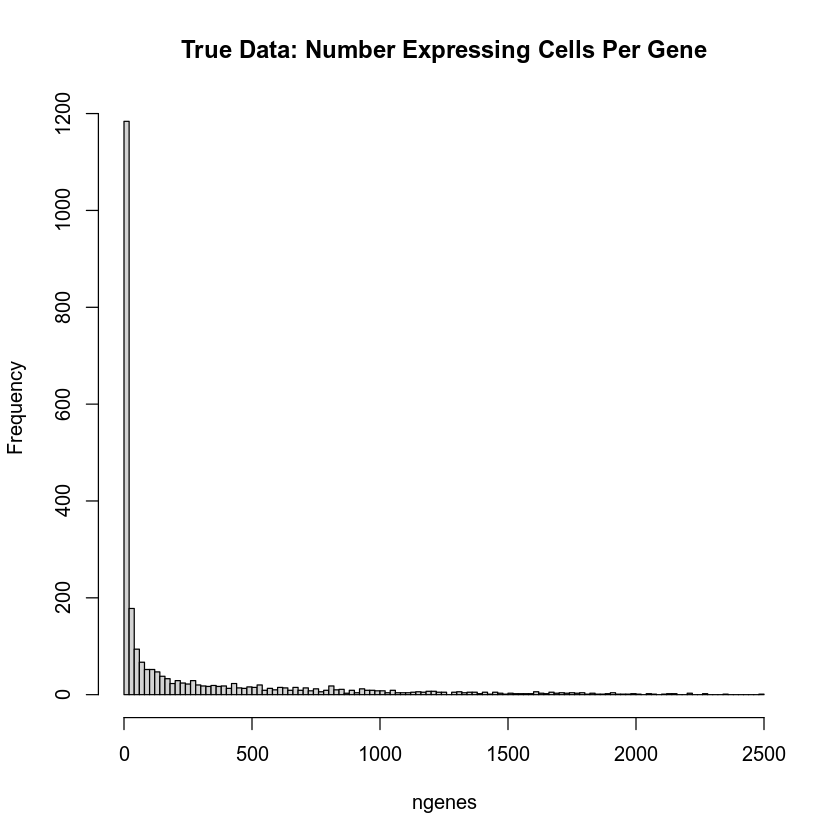

In [27]:
# plot number of expressed cells per gene
ngenes = apply( sim_exp != 0 , 1 , sum )
hist(ngenes,breaks=100, main = "Simulated: Number Expressing Cells Per Gene")

# plot number of expressed cells per gene
ngenes = apply( true_exp != 0 , 1 , sum )
hist(ngenes,breaks=100, main = "True Data: Number Expressing Cells Per Gene")

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 295 features requested have zero variance (running reduction without them): AL645730.1, BORCS8, AC087289.1, AL391094.1, LINC02031, LINC00431, AL157902.1, AC091607.1, LINC01973, HSP90AA5P, AC062022.1, AC131094.1, AL049610.1, AC005077.4, LINC02029, SUMO2P18, CCL16, RN7SKP209, NKX2-5, AC124784.1, LINC01735, AC025062.3, AL133465.1, AC126177.7, LYNX1-SLURP2, YPEL5P2, RF00017.128, AC027013.1, SLC9B1P3, C18orf65, SCGB3A1, BNIP3P41, RF00017.119, AC012615.5, SHB, RNU4-67P, AC138089.1, AC040169.2, OR4C1P, CALM2P3, AL157931.2, UGT2B15, LINC01936, DUXAP11, AL109807.1, SMIM23, HLA-T, AL021391.1, SIGLEC18P, CLEC12A-AS1, LINC01734, AC063949.1, RPL29P11, AC104996.1, AC091564.4, STATH, AC079779.3, DPEP2NB, AC063949.2, AP001331.1, LINC02464, MTX1P1, AC011477.5, AC007998.4, ASS1P5, LINC00557, AL390763.1, AC148477.4, AC073323.1, AC004945.1, AC006557.5, EIF4EP1, HOXB2, LINC0

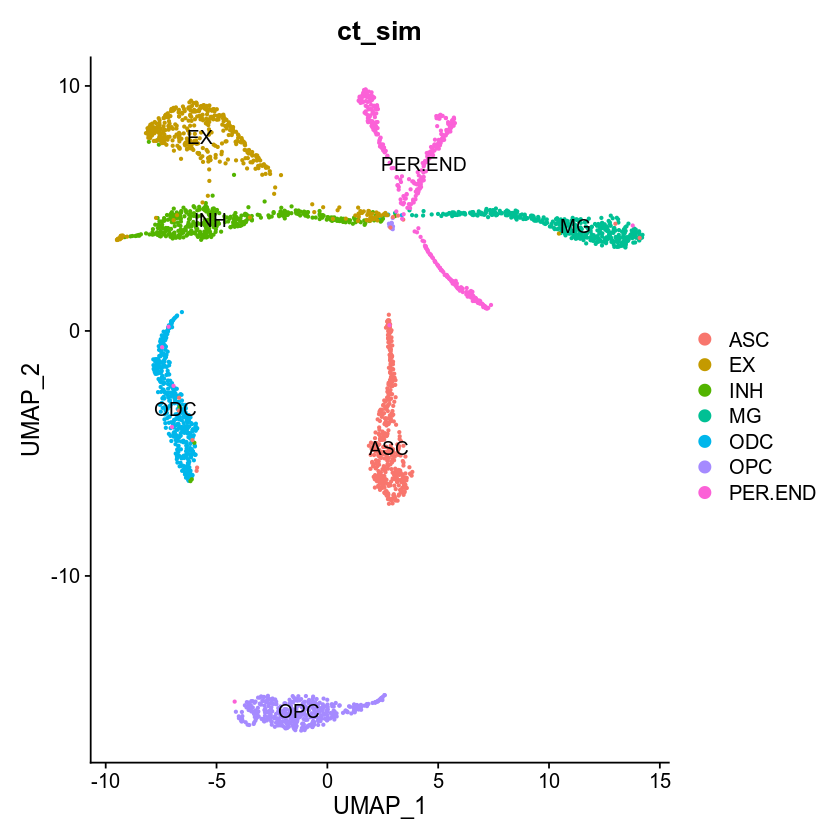

In [385]:
# create umap for true data
sim_exp_seu = CreateSeuratObject(true_exp)
# colnames(sim_exp) = paste0("cell", 1:dim(sim_exp)[2])
# sim_exp_seu = CreateSeuratObject(sim_exp)

ct = data.frame(ct_sim)
rownames(ct) = colnames(sim_exp_seu)
sim_exp_seu <- AddMetaData(sim_exp_seu, ct, col.name = NULL)
sim_exp_seu <- NormalizeData(sim_exp_seu, normalization.method = "LogNormalize", scale.factor = 10000)
all.genes <- rownames(sim_exp_seu)
sim_exp_seu <- ScaleData(sim_exp_seu, features = all.genes)
sim_exp_seu <- RunPCA(sim_exp_seu, features = all.genes)
sim_exp_seu <- RunUMAP(sim_exp_seu, dims = 1:10)
DimPlot(sim_exp_seu, reduction = "umap", label=T, group.by="ct_sim")

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 305 features requested have zero variance (running reduction without them): AL391094.1, LINC02031, LINC01393, AL157902.1, TM4SF19-TCTEX1D2, AC091607.1, ATP5F1AP10, HSP90AA5P, AL139811.2, AGAP5, AC120024.4, AC062022.1, AC131094.1, AL049610.1, AC108861.1, AP002414.4, LINC02029, CCL16, AC027804.1, NKX2-5, OR1A1, HNRNPA1P54, AC124784.1, AC025062.3, RF00272, AL133465.1, AC126177.7, AC007493.2, LINC02592, RF00017.128, TPI1P1, CGA, RF00017.119, AC007663.2, AL355075.2, AC012615.5, SAP18P2, AC138089.1, AC040169.2, OR4C1P, AL049844.2, UGT2B15, LACTBL1, TXNP1, AL109807.1, AC078882.1, KRT18P13, SMIM23, RN7SL58P, LINC01734, RPL29P11, AC091564.4, STATH, AC079779.3, DPEP2NB, DEFB136, AC063949.2, AL158068.1, LSINCT5, AP001331.1, RN7SKP243, AC011477.5, HIST1H2BK, RNU6-1046P, ASS1P5, DSCAM-AS1, ARL2BPP3, AC148477.4, KRT8P7, AC004945.1, AC006557.5, AL078624.1, EIF4EP1, AC1

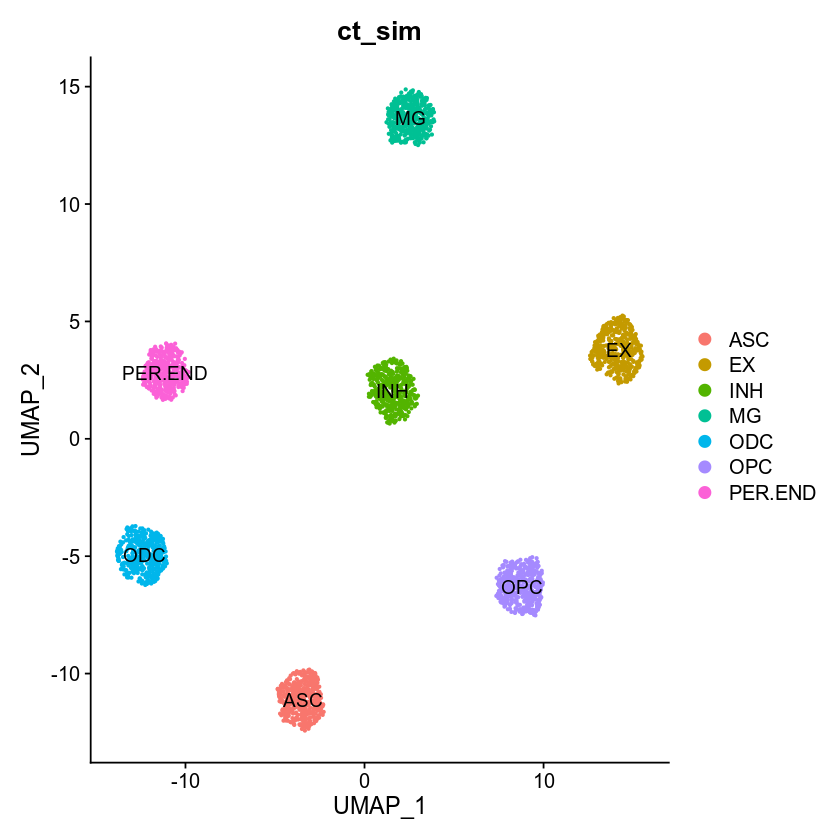

In [386]:
# create umap for simulated data
colnames(sim_exp) = paste0("cell", 1:dim(sim_exp)[2])
sim_exp_seu = CreateSeuratObject(sim_exp)

ct = data.frame(ct_sim)
rownames(ct) = colnames(sim_exp_seu)
sim_exp_seu <- AddMetaData(sim_exp_seu, ct, col.name = NULL)
sim_exp_seu <- NormalizeData(sim_exp_seu, normalization.method = "LogNormalize", scale.factor = 10000)
all.genes <- rownames(sim_exp_seu)
sim_exp_seu <- ScaleData(sim_exp_seu, features = all.genes)
sim_exp_seu <- RunPCA(sim_exp_seu, features = all.genes)
sim_exp_seu <- RunUMAP(sim_exp_seu, dims = 1:10)
DimPlot(sim_exp_seu, reduction = "umap", label=T, group.by="ct_sim")